In [1]:
import os
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit

In [2]:
# Cargo el excel de la EPH
eph_todo = pd.read_csv("eph_panel.csv")

C:\Users\felip\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (102,179,182,187,207,209) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
eph_todo = eph_todo.drop_duplicates(subset=["CODUSU","COMPONENTE","ANO4","TRIMESTRE"])

In [4]:
eph_todo.head(5)

,CODUSU,NRO_HOGAR,TRIMESTRE,ANO4,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNOPPQHJKKTCDEHMHF00479193,1,2,2016,1,1,42,N,26,165,...,2,2,0,2,2,0,98,0,0,0
1,TQRMNOPPQHJKKTCDEHMHF00479193,1,3,2016,1,1,42,N,26,176,...,2,2,0,2,2,0,98,0,0,0
2,TQRMNOPPQHJKKTCDEHMHF00479193,1,2,2017,1,1,42,N,26,159,...,2,2,0,2,2,0,98,0,0,0
3,TQRMNOPPQHJKKTCDEHMHF00479193,1,3,2017,1,1,42,N,26,171,...,2,2,0,2,2,1,98,0,0,0
4,TQRMNOPPQHJKKTCDEHMHF00479193,1,2,2016,2,1,42,N,26,165,...,2,2,0,2,2,0,98,0,0,0


In [5]:
def limpiar_eph(eph):

    '''
        función para limpiar la eph
        input:
            eph: Variable que tenga almacenada la eph sin limpiar

        output:
            eph: Variable que tiene almacenada la eph limpia
    '''
    
    eph.dropna(thresh = 1, inplace = True) # Si tiene todos NA, la fila se va
    
    eph.dropna(thresh = 1, axis = "columns", inplace = True) # Si la columna tiene todos NA, la columna se va
    
    try:
        # Si no lo defino como uno me dropea un montón de filas que tienen NaN
        eph.PP08D1 = eph.PP08D1.fillna(0)
        # dropeo observaciones con valores que no tienen sentido. CH06 = edad, PP08D1, P21, P47T, ITF y IPCF son todas variables
        # de ingresos, no pueden ser menores a 0
        eph.fillna(0, inplace = True) # Relleno todos con 0 los missing de las columnas que representan subcategorías en
        #las que solo respondieron algunos. 
        eph.reset_index(inplace = True, drop = True)  
    except:
        print("No se encontró alguna columna, revisar")   

In [74]:
columnas_ing = ["CODUSU","ANO4","TRIMESTRE","COMPONENTE","AGLOMERADO","MAS_500","CH04","CH06","CH08","PP02E",
"CH09","CH10","CH11","CH12","CH13","CH15","CH07","CH16","NIVEL_ED","ESTADO","CAT_OCUP","CAT_INAC","PP04B3_ANO",
"PP03G","PP03I","INTENSI","PP11T","PP11S","PP11O","PP11N","PP11L1","PP10D","PP10A","PP10C","PP07H","PP07G4","PP11A",
"PP10E","PP09C","PP07K","PP07G_59","PP07G2","PP07G1","PP07C","PP07A","PP05H","PP04G","IV2","IV11","IV12_3","IV1", 
"PONDERA","II7","II8","II9","V5","V17","IV3","V4","IV6","IV7","IV8","IV9","V3","V6","V8","PP02I","PP3E_TOT","PP3F_TOT",
"IV10","IV11","II4_1","II4_2","II4_3","V1","V2","V9","V10","V13","V14","V15","V18","IX_TOT","IX_MEN10","ITF","DECIFR",
"ADECIFR","IPCF","DECCFR","ADECCFR","PONDIH","PP08D1","P21","DECOCUR","TOT_P12","P47T"]

columnas = ["CODUSU","ANO4","TRIMESTRE","COMPONENTE","AGLOMERADO","MAS_500","CH04","CH06","CH08","PP02E","PP02I",
"CH09","CH10","CH11","CH12","CH13","CH15","CH07","CH16","NIVEL_ED","ESTADO","CAT_OCUP","CAT_INAC","PP04B3_ANO",
"PP03G","PP03I","INTENSI","PP11T","PP11S","PP11O","PP11N","PP11L1","PP10D","PP10A","PP10C","PP07H","PP07G4","PP11A",
"PP10E","PP09C","PP07K","PP07G_59","PP07G2","PP07G1","PP07C","PP07A","PP05H","PP04G","IV2","IV11","IV12_3","IV1", 
"PONDERA","II7","II8","II9","V5","V17","IV3","V4","IV6","IV7","IV8","IV9","V3","V6","V8","PP3E_TOT","PP3F_TOT",
"IV10","IV11","II4_1","II4_2","II4_3","V1","V2","V9","V10","V13","V14","V15","V18","IX_TOT","IX_MEN10"]

In [7]:
eph = eph_todo[columnas_ing]

In [8]:
limpiar_eph(eph)

<ipython-input-5-7d9f8ee8e7f0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eph.dropna(thresh = 1, inplace = True) # Si tiene todos NA, la fila se va
<ipython-input-5-7d9f8ee8e7f0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eph.dropna(thresh = 1, axis = "columns", inplace = True) # Si la columna tiene todos NA, la columna se va
C:\Users\felip\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [9]:
eph["CH06"] = eph["CH06"].replace(-1, 35)

<ipython-input-9-4366311f0076>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eph["CH06"] = eph["CH06"].replace(-1, 35)


In [10]:
#Importamos la tabla de excel
tabla_adulto = pd.read_excel("tabla_adulto_equiv.xlsx", header = 3)
#Ajustamos el formato de la tabla 
tabla_adulto.dropna(axis = 1, inplace = True, thresh = 10)
tabla_adulto.dropna(inplace = True, thresh = 3)
tabla_adulto.reset_index(inplace = True, drop = True)
#Creamos la columna "adulto_equiv" como una columna de ceros
eph["adulto_equiv"] = 0
#Generamos una nueva columna llamada lista como una columna de ceros 
eph["lista"] = 0
#Iteramos por filas
#Para cada fila del data frame de acuerdo a la edad le indicamos que 
#la celda de la columna "lista" la complete con el número correspondiente 
#al índice de la tabla_adulto. 
#Por ejemplo, si la edad es menor a 30 entonces se asigna el numero 18 que es
#el índice de la fila de 18 a 29 años. 
for i in eph.index:
    if eph.loc[i, "CH06"] < 19:
        eph.loc[i, "lista"] = eph.loc[i, "CH06"]
    elif eph.loc[i, "CH06"] < 30:
        eph.loc[i, "lista"] = 18
    elif eph.loc[i, "CH06"] < 46:
        eph.loc[i, "lista"] = 19
    elif eph.loc[i, "CH06"] < 61:
        eph.loc[i, "lista"] = 20
    elif eph.loc[i, "CH06"] < 76:
        eph.loc[i, "lista"] = 21
    else:
        eph.loc[i, "lista"] = 22
#CH06 = edad, CH04 = Sexo (1 = varon y 2 = mujer)
#Para cada fila del dataframe si el individuo es varón entonces le indicamos que bajo 
#la columna "adulto_equiv" coloque la siguiente celda de tabla_adulto: 
# Fila: el índice que esta guardado en la columna "lista" en el df eph. 
# Columna: Varones 
#idem para las mujeres
#De este modo se obtienen los valores de adulto equivalente de cada persona según 
#su sexo y edad
for i in eph.index:
    if eph.loc[i, "CH04"] == 1:
        eph.loc[i, "adulto_equiv"] = tabla_adulto.loc[eph.loc[i, "lista"], "Varones"]
    elif eph.loc[i, "CH04"] == 2:
        eph.loc[i, "adulto_equiv"] = tabla_adulto.loc[eph.loc[i, "lista"], "Mujeres"]
#Eliminamos la columna "lista"
eph.drop("lista", axis = 1, inplace = True)
#Realizamos un groupby: para cada hogar sumamos "adulto_equiv"
ad_equiv_hogar = eph[["CODUSU","ANO4","TRIMESTRE","adulto_equiv"]].groupby(["CODUSU","ANO4","TRIMESTRE"]).sum()
ad_equiv_hogar.reset_index(inplace = True)
#cambiamos los nombres de las columnas
ad_equiv_hogar.columns = ["CODUSU","ANO4","TRIMESTRE","ad_equiv_hogar"]
#agregamos la columnna "ad_equiv_hogar" al df eph
eph = eph.merge(ad_equiv_hogar, on = ["CODUSU","ANO4","TRIMESTRE"], how = "left")

<ipython-input-10-7bbed948d211>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eph["adulto_equiv"] = 0
<ipython-input-10-7bbed948d211>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eph["lista"] = 0
C:\Users\felip\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [11]:
# Dividimos la muestra de la EPH en gente que no respondió ingresos totales familiares (ITF) y los que sí.
norespondieron = eph[eph["ITF"] <= 0]
norespondieron.reset_index(inplace = True, drop = True)
respondieron = eph[eph["ITF"] > 0]
respondieron.reset_index(inplace = True, drop = True)

In [12]:
test = respondieron.groupby(["CODUSU","COMPONENTE"]).agg({"ANO4":"count"})
test.reset_index(inplace = True)
test.rename(columns={'ANO4': 'aparece'}, inplace=True)
respondieron = respondieron.merge(test, on = ["CODUSU","COMPONENTE"], how = "left")
respondieron = respondieron[respondieron["aparece"]==4]
respondieron.drop("aparece",axis=1,inplace=True)

In [13]:
# Ingresos mínimos por trimestre, hice un promedio del CBT por trimestre.
im_2t_2016 = 3812
im_3t_2016 = 4055
im_4t_2016 = 4232
im_1t_2017 = 4432
im_2t_2017 = 4744
im_3t_2017 = 4932
im_4t_2017 = 5219

# Creamos una columna de ingreso necesario para no ser pobre y la rellenamos con el for loop teniendo en cuenta el año
# y trimestre. Toma valores dependiendo de la columna ad_equiv_hogar * ingreso minimo per cápita.
respondieron["ingreso_necesario"] = 0
for i in respondieron.index:
    if (respondieron.loc[i, "ANO4"] == 2016) & (respondieron.loc[i, "TRIMESTRE"] == 2):
        respondieron.loc[i, "ingreso_necesario"] = im_2t_2016 * respondieron.loc[i,"ad_equiv_hogar"]
    elif (respondieron.loc[i, "ANO4"] == 2016) & (respondieron.loc[i, "TRIMESTRE"] == 3):
        respondieron.loc[i, "ingreso_necesario"] = im_3t_2016 * respondieron.loc[i,"ad_equiv_hogar"]
    elif (respondieron.loc[i, "ANO4"] == 2016) & (respondieron.loc[i, "TRIMESTRE"] == 4):
        respondieron.loc[i, "ingreso_necesario"] = im_4t_2016 * respondieron.loc[i,"ad_equiv_hogar"]
    elif (respondieron.loc[i, "ANO4"] == 2017) & (respondieron.loc[i, "TRIMESTRE"] == 1):
        respondieron.loc[i, "ingreso_necesario"] = im_1t_2017 * respondieron.loc[i,"ad_equiv_hogar"]
    elif (respondieron.loc[i, "ANO4"] == 2017) & (respondieron.loc[i, "TRIMESTRE"] == 2):
        respondieron.loc[i, "ingreso_necesario"] = im_2t_2017 * respondieron.loc[i,"ad_equiv_hogar"]
    elif (respondieron.loc[i, "ANO4"] == 2017) & (respondieron.loc[i, "TRIMESTRE"] == 3):
        respondieron.loc[i, "ingreso_necesario"] = im_3t_2017 * respondieron.loc[i,"ad_equiv_hogar"]
    elif (respondieron.loc[i, "ANO4"] == 2017) & (respondieron.loc[i, "TRIMESTRE"] == 4):
        respondieron.loc[i, "ingreso_necesario"] = im_4t_2017 * respondieron.loc[i,"ad_equiv_hogar"]
        
# Creamos una columna dummy, que dice si el individuo es pobre o no. Depende de si sus ingresos
# son mayores a ingreso_necesario
respondieron["pobre"] = (respondieron["ITF"] < respondieron["ingreso_necesario"]).astype(int)

# Estadística descriptiva

In [14]:
eph_pob = respondieron.groupby(["CODUSU","ANO4","TRIMESTRE"]).agg({"PONDIH":"mean","pobre":"mean"})
eph_pob.reset_index(inplace=True)
pon_pob_t2_16 = eph_pob[(eph_pob["pobre"] == 1) & (eph_pob["TRIMESTRE"] == 2) & 
                        (eph_pob["ANO4"] == 2016)].apply({"PONDIH":"sum"})
pon_pob_t3_16 = eph_pob[(eph_pob["pobre"] == 1) & (eph_pob["TRIMESTRE"] == 3) & 
                        (eph_pob["ANO4"] == 2016)].apply({"PONDIH":"sum"})
pon_pob_t4_16 = eph_pob[(eph_pob["pobre"] == 1) & (eph_pob["TRIMESTRE"] == 4) & 
                        (eph_pob["ANO4"] == 2016)].apply({"PONDIH":"sum"})
pon_pob_t2_17 = eph_pob[(eph_pob["pobre"] == 1) & (eph_pob["TRIMESTRE"] == 2) & 
                        (eph_pob["ANO4"] == 2017)].apply({"PONDIH":"sum"})
pon_pob_t3_17 = eph_pob[(eph_pob["pobre"] == 1) & (eph_pob["TRIMESTRE"] == 3) & 
                        (eph_pob["ANO4"] == 2017)].apply({"PONDIH":"sum"})
pon_pob_t4_17 = eph_pob[(eph_pob["pobre"] == 1) & (eph_pob["TRIMESTRE"] == 4) & 
                        (eph_pob["ANO4"] == 2017)].apply({"PONDIH":"sum"})
pon_tot_t2_16 = eph_pob[(eph_pob["TRIMESTRE"] == 2) & (eph_pob["ANO4"] == 2016)].apply({"PONDIH":"sum"})
pon_tot_t3_16 = eph_pob[(eph_pob["TRIMESTRE"] == 3) & (eph_pob["ANO4"] == 2016)].apply({"PONDIH":"sum"})
pon_tot_t4_16 = eph_pob[(eph_pob["TRIMESTRE"] == 4) & (eph_pob["ANO4"] == 2016)].apply({"PONDIH":"sum"})
pon_tot_t2_17 = eph_pob[(eph_pob["TRIMESTRE"] == 2) & (eph_pob["ANO4"] == 2017)].apply({"PONDIH":"sum"})
pon_tot_t3_17 = eph_pob[(eph_pob["TRIMESTRE"] == 3) & (eph_pob["ANO4"] == 2017)].apply({"PONDIH":"sum"})
pon_tot_t4_17 = eph_pob[(eph_pob["TRIMESTRE"] == 4) & (eph_pob["ANO4"] == 2017)].apply({"PONDIH":"sum"})
ratio = {"2016_t2":pon_pob_t2_16.item()/pon_tot_t2_16.item(),"2016_t3":pon_pob_t3_16.item()/pon_tot_t3_16.item(),
         "2016_t4":pon_pob_t4_16.item()/pon_tot_t4_16.item(),"2017_t2":pon_pob_t2_17.item()/pon_tot_t2_17.item(),
         "2017_t3":pon_pob_t3_17.item()/pon_tot_t3_17.item(),"2017_t4":pon_pob_t4_17.item()/pon_tot_t4_17.item()}

In [15]:
#Calculamos en cuantos trimestres en total individuos se encontraron en situación de Pobreza 
respondieron.pobre.sum()

15210

In [16]:
gente_pobre = respondieron.groupby(["CODUSU","COMPONENTE"]).agg({"pobre":"max"})

In [17]:
gente_pobre

pobre
CODUSU                        COMPONENTE       
TQRMNOPPQHJKKTCDEHMHF00479193 1               0
                              2               0
TQRMNOPPQHJMKRCDEFOCD00472238 1               1
                              2               1
                              3               1
...                                         ...
TQUMNOPQUHJMLOCDEFMDB00471489 3               1
TQUMNOPXSHKNKPCDEIHJF00494381 1               0
                              2               0
TQVMNOPXSHKNKPCDEIHJF00494445 1               0
                              2               0

[11008 rows x 1 columns]

In [18]:
#Calculamos cuanta gente fue pobre en al menos uno de los 4 perídos
gente_pobre.pobre.sum()

5570

In [19]:
#Cuanta gente hay en la muestra
gente_pobre.pobre.count()

11008

In [20]:
5570/11008

0.5059956395348837

El 50% de las personas fue pobre en al menos 1 de los 4 períodos. 

In [21]:
ratio

{'2016_t2': 0.22387206681571326,
 '2016_t3': 0.2000394477160845,
 '2016_t4': 0.20205662475378344,
 '2017_t2': 0.20168084201320816,
 '2017_t3': 0.17904432513710022,
 '2017_t4': 0.16948532346355336}

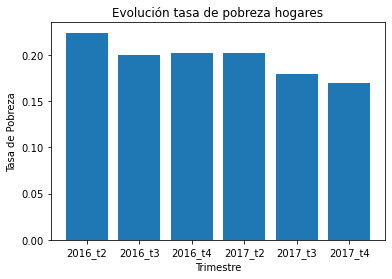

In [22]:
#Graficamos la evolución de la Tasa de Pobreza
eje_x = list(ratio.keys())
eje_y = list(ratio.values())
plt.bar(eje_x, eje_y)
plt.ylabel('Tasa de Pobreza')
plt.xlabel("Trimestre")
plt.title('Evolución tasa de pobreza hogares')
plt.show()

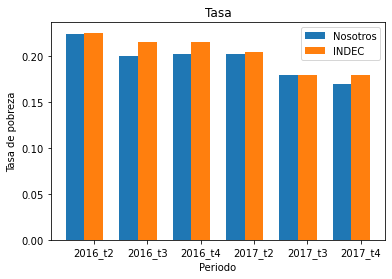

In [25]:
ratio_indec = {"2016_t2": 0.225,"2016_t3": 0.215,
         "2016_t4": 0.215,"2017_t2": 0.204,
         "2017_t3": 0.179,"2017_t4":0.179}

lista_ratio = ratio.values()
lista_ratio = list(lista_ratio)
lista_ratio
lista_ratio_indec = ratio_indec.values()
lista_ratio_indec = list(lista_ratio_indec)
lista_ratio_indec
lista_ano = ratio.keys()
lista_ano = list(lista_ano)
lista_ratio

numero_de_grupos = len(lista_ratio)
indice_barras = np.arange(numero_de_grupos)
ancho_barras =0.35
 
plt.bar(indice_barras, lista_ratio, width=ancho_barras, label='Nosotros')
plt.bar(indice_barras + ancho_barras, lista_ratio_indec, width=ancho_barras, label='INDEC')
plt.legend(loc='best')
## Se colocan los indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, (lista_ano))
 
plt.ylabel("Tasa de pobreza")
plt.xlabel('Periodo')
plt.title('Tasa')
 
plt.show()

In [26]:
#Agregamos a cada observación una columna que indica si fue pobre o no en el periodo siguiente. 
#NOTAR: Las ultimas observaciones de cada individuo no tienen sentido
respondieron['pobre_prox'] = respondieron['pobre'].shift(-1)

### Calculamos cantidad de personas que entran a la pobreza y cantidad que salen entre periodos

In [27]:
respondieron.reset_index(inplace=True,drop=True)

In [28]:
respondieron["j"]=0
respondieron["i"]=0
respondieron["j"] = [1 if index >= 22268 else 0 for index in respondieron.index]
respondieron["i"] = [1 if index < 22268 else 0 for index in respondieron.index]

In [29]:
#Calculamos transición de segundo a tercer trimestre de 2016
muestra_t2_2016 = respondieron[(respondieron["TRIMESTRE"] == 2) & (respondieron["ANO4"] == 2016)].pobre.count()

per_t2_2016 = respondieron[(respondieron["TRIMESTRE"] == 2) & (respondieron["ANO4"] == 2016)].pobre.sum()
pobres_t2a3_16 = respondieron[(respondieron["TRIMESTRE"]==2)&
                           (respondieron["ANO4"]==2016)&
                           (respondieron["pobre"]==1)].pobre_prox.sum()
salen_t2a3_16 = respondieron[(respondieron["TRIMESTRE"]==2)&
                          (respondieron["ANO4"]==2016)&(respondieron["pobre"]==1)&
                          (respondieron["pobre_prox"]==0)].pobre_prox.count()
chetos_t2_16 = muestra_t2_2016 - per_t2_2016
entran_t2a3_16 = respondieron[(respondieron["TRIMESTRE"]==2)&
                           (respondieron["ANO4"]==2016)&
                           (respondieron["pobre"]==0)&
                           (respondieron["pobre_prox"]==1)].pobre_prox.count()
no_vulnerables = respondieron[(respondieron["TRIMESTRE"]==2)&
                              (respondieron["ANO4"]==2016)&
                              (respondieron["pobre"]==0)&
                              (respondieron["pobre_prox"]==0)].pobre_prox.count()

In [30]:
#Calculamos porcentaje de cada una de las 4 posibilidades
t2_t3_16 = {"pobres":pobres_t2a3_16/per_t2_2016,"salen":salen_t2a3_16/per_t2_2016,
            "entran":entran_t2a3_16/chetos_t2_16,"no_vulnerables":no_vulnerables/chetos_t2_16}
t2_t3_16

{'pobres': 0.7732151189920672,
 'salen': 0.22678488100793281,
 'entran': 0.10251168224299065,
 'no_vulnerables': 0.8974883177570093}

Interpretación:

-El 75% de los pobres en t2, es pobre en t3. 

-El 25% de los pobres en t2, NO es pobre en t3. 

-El 10% de los no pobres en t2, es pobre en t3. 

-El 90% de los no pobres en t2, NO es pobre en t3.

In [31]:
#Calculamos transición de tercer a cuarto trimestre de 2016
muestra_t3_2016 = respondieron[(respondieron["TRIMESTRE"] == 3) & 
                               (respondieron["ANO4"] == 2016) & 
                               (respondieron["j"]==1)].pobre.count()

per_t3_2016 = respondieron[(respondieron["TRIMESTRE"] == 3) & 
                           (respondieron["ANO4"] == 2016)& 
                           (respondieron["j"]==1)].pobre.sum()
pobres_t3a4_16 = respondieron[(respondieron["TRIMESTRE"]==3)&
                           (respondieron["ANO4"]==2016)&
                           (respondieron["pobre"]==1)&
                          (respondieron["j"]==1)].pobre_prox.sum()
salen_t3a4_16 = respondieron[(respondieron["TRIMESTRE"]==3)&
                          (respondieron["ANO4"]==2016)&
                          (respondieron["pobre"]==1)&
                          (respondieron["pobre_prox"]==0)&
                          (respondieron["j"]==1)].pobre_prox.count()
chetos_t3_16 = muestra_t3_2016 - per_t3_2016
entran_t3a4_16 = respondieron[(respondieron["TRIMESTRE"]==3)&
                           (respondieron["ANO4"]==2016)&
                           (respondieron["pobre"]==0)&
                           (respondieron["pobre_prox"]==1)&
                           (respondieron["j"]==1)].pobre_prox.count()
no_vulnerables_2 = respondieron[(respondieron["TRIMESTRE"]==3)&
                              (respondieron["ANO4"]==2016)&
                              (respondieron["pobre"]==0)&
                              (respondieron["pobre_prox"]==0)&
                            (respondieron["j"]==1)].pobre_prox.count()

#Calculamos porcentaje de cada una de las 4 posibilidades
t3_t4_16 = {"pobres": pobres_t3a4_16/per_t3_2016, "salen": salen_t3a4_16/per_t3_2016,
         "entran": entran_t3a4_16/chetos_t3_16, "no_vulnerables": no_vulnerables_2/chetos_t3_16}
t3_t4_16

{'pobres': 0.7906137184115524,
 'salen': 0.20938628158844766,
 'entran': 0.1327812678469446,
 'no_vulnerables': 0.8672187321530554}

In [32]:
#Calculamos transición de segundo a tercer trimestre de 2017
muestra_t2_2017 = respondieron[(respondieron["TRIMESTRE"] == 2) & 
                               (respondieron["ANO4"] == 2017)].pobre.count()

per_t2_2017 = respondieron[(respondieron["TRIMESTRE"] == 2) & 
                           (respondieron["ANO4"] == 2017)].pobre.sum()
pobres_t2a3_17 = respondieron[(respondieron["TRIMESTRE"]==2)&
                           (respondieron["ANO4"]==2017)&
                           (respondieron["pobre"]==1)].pobre_prox.sum()
salen_t2a3_17 = respondieron[(respondieron["TRIMESTRE"]==2)&
                          (respondieron["ANO4"]==2017)&
                             (respondieron["pobre"]==1)&
                          (respondieron["pobre_prox"]==0)].pobre_prox.count()
chetos_t2_17 = muestra_t2_2017 - per_t2_2017
entran_t2a3_17 = respondieron[(respondieron["TRIMESTRE"]==2)&
                           (respondieron["ANO4"]==2017)&
                           (respondieron["pobre"]==0)&
                           (respondieron["pobre_prox"]==1)].pobre_prox.count()
no_vulnerables_3 = respondieron[(respondieron["TRIMESTRE"]==2)&
                              (respondieron["ANO4"]==2017)&
                              (respondieron["pobre"]==0)&
                              (respondieron["pobre_prox"]==0)].pobre_prox.count()

#Calculamos porcentaje de cada una de las 4 posibilidades
t2_t3_17 = {"pobres": pobres_t2a3_17/per_t2_2017, "salen": salen_t2a3_17/per_t2_2017,
         "entran": entran_t2a3_17/chetos_t2_17, "no_vulnerables": no_vulnerables_3/chetos_t2_17}
t2_t3_17

{'pobres': 0.7350959046137895,
 'salen': 0.26490409538621046,
 'entran': 0.1011544804837823,
 'no_vulnerables': 0.8988455195162177}

In [33]:
#Calculamos transición de tercer a cuarto trimestre de 2017
muestra_t3_2017 = respondieron[(respondieron["TRIMESTRE"] == 3) & (respondieron["ANO4"] == 2017) & (respondieron["j"]==1)].pobre.count()

per_t3_2017 = respondieron[(respondieron["TRIMESTRE"] == 3) & 
                           (respondieron["ANO4"] == 2017)& 
                           (respondieron["j"]==1)].pobre.sum()
pobres_t3a4_17 = respondieron[(respondieron["TRIMESTRE"]==3)&
                           (respondieron["ANO4"]==2017)&
                           (respondieron["pobre"]==1)&
                          (respondieron["j"]==1)].pobre_prox.sum()
salen_t3a4_17 = respondieron[(respondieron["TRIMESTRE"]==3)&
                          (respondieron["ANO4"]==2017)&
                          (respondieron["pobre"]==1)&
                          (respondieron["pobre_prox"]==0)&
                          (respondieron["j"]==1)].pobre_prox.count()
chetos_t3_17 = muestra_t3_2017 - per_t3_2017
entran_t3a4_17 = respondieron[(respondieron["TRIMESTRE"]==3)&
                           (respondieron["ANO4"]==2017)&
                           (respondieron["pobre"]==0)&
                           (respondieron["pobre_prox"]==1)&
                           (respondieron["j"]==1)].pobre_prox.count()
no_vulnerables_4 = respondieron[(respondieron["TRIMESTRE"]==3)&
                              (respondieron["ANO4"]==2017)&
                              (respondieron["pobre"]==0)&
                              (respondieron["pobre_prox"]==0)&
                            (respondieron["j"]==1)].pobre_prox.count()

#Calculamos porcentaje de cada una de las 4 posibilidades
t3_t4_17 = {"pobres": pobres_t3a4_17/per_t3_2017, "salen": salen_t3a4_17/per_t3_2017,
         "entran": entran_t3a4_17/chetos_t3_17, "no_vulnerables": no_vulnerables_4/chetos_t3_17}
t3_t4_17

{'pobres': 0.7648845686512759,
 'salen': 0.23511543134872417,
 'entran': 0.13227931488801054,
 'no_vulnerables': 0.8677206851119894}

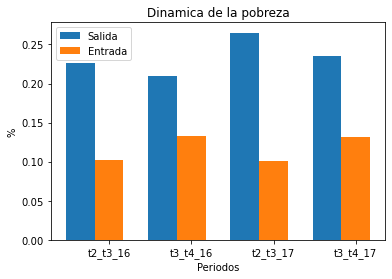

In [34]:
periodos = ["t2_t3_16", "t3_t4_16", "t2_t3_17", "t3_t4_17"]
salen= [0.2267, 0.2093, 0.2649, 0.2351]
entran = [0.1025, 0.1327, 0.1011, 0.1322]
numero_de_grupos = len(salen)
indice_barras = np.arange(numero_de_grupos)
ancho_barras =0.35
 
plt.bar(indice_barras, salen, width=ancho_barras, label='Salida')
plt.bar(indice_barras + ancho_barras, entran, width=ancho_barras, label='Entrada')
plt.legend(loc='best')
## Se colocan los indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, (periodos))
 
plt.ylabel("%")
plt.xlabel('Periodos')
plt.title('Dinamica de la pobreza')

plt.show()

# INTERPRETACIÓN:

- AZUL: Porcentaje de pobres que logran salir de la pobreza

- NARANJA: Porcentaje de NO pobres que entran en la pobreza 

# Resultados: 
    
- Entre el 20 y el 25% de los pobres logran salir de la pobreza entre períodos. 

- Entre el 10 y 15% de los no pobres cae en la pobreza entre periodos. 

In [35]:
#Columna pobre_final
poner1i = respondieron[(respondieron["pobre"]==1) & (respondieron["TRIMESTRE"]==3) & (respondieron["ANO4"]==2017) & 
             (respondieron["i"]==1)][["CODUSU","COMPONENTE"]]
poner1i["pobre_final"]=1
poner1j = respondieron[(respondieron["pobre"]==1) & (respondieron["TRIMESTRE"]==4) & (respondieron["ANO4"]==2017) & 
             (respondieron["j"]==1)][["CODUSU","COMPONENTE"]]
poner1j["pobre_final"]=1
poner1 = pd.merge(poner1i,poner1j,how="outer",on=["CODUSU","COMPONENTE","pobre_final"])
respondieron = respondieron.merge(poner1,on = ["CODUSU","COMPONENTE"],how = "outer")
respondieron.fillna(0,inplace=True)

#Columna pobre_anual
poner1i_anual = respondieron[(respondieron["pobre"]==1) & (respondieron["TRIMESTRE"]==2) & (respondieron["ANO4"]==2017) & 
             (respondieron["i"]==1)][["CODUSU","COMPONENTE"]]
poner1i_anual["pobre_anual"]=1
poner1i2_anual = respondieron[(respondieron["pobre"]==1) & (respondieron["TRIMESTRE"]==3) & (respondieron["ANO4"]==2017) & 
             (respondieron["i"]==1)][["CODUSU","COMPONENTE"]]
poner1i2_anual["pobre_anual"]=1
poner1j_anual = respondieron[(respondieron["pobre"]==1) & (respondieron["TRIMESTRE"]==3) & (respondieron["ANO4"]==2017) & 
             (respondieron["j"]==1)][["CODUSU","COMPONENTE"]]
poner1j_anual["pobre_anual"]=1
poner1j2_anual = respondieron[(respondieron["pobre"]==1) & (respondieron["TRIMESTRE"]==4) & (respondieron["ANO4"]==2017) & 
             (respondieron["j"]==1)][["CODUSU","COMPONENTE"]]
poner1j2_anual["pobre_anual"]=1
poner1_anual_i = pd.merge(poner1i_anual,poner1i2_anual,how="outer",on=["CODUSU","COMPONENTE","pobre_anual"])
poner1_anual_j = pd.merge(poner1j_anual,poner1j2_anual,how="outer",on=["CODUSU","COMPONENTE","pobre_anual"])
poner1_anual = pd.merge(poner1_anual_i,poner1_anual_j,how="outer",on=["CODUSU","COMPONENTE","pobre_anual"])
respondieron = respondieron.merge(poner1_anual,on = ["CODUSU","COMPONENTE"],how = "outer")
respondieron.fillna(0,inplace=True)

### Clasificación de la vulnerabilidad de las personas según cuántos periodos estuvieron bajo la línea de pobreza

In [36]:
vulnerabilidad = respondieron.groupby(["CODUSU","COMPONENTE"]).agg({"pobre":"sum"})
vulnerabilidad

pobre
CODUSU                        COMPONENTE       
TQRMNOPPQHJKKTCDEHMHF00479193 1               0
                              2               0
TQRMNOPPQHJMKRCDEFOCD00472238 1               3
                              2               3
                              3               3
...                                         ...
TQUMNOPQUHJMLOCDEFMDB00471489 3               2
TQUMNOPXSHKNKPCDEIHJF00494381 1               0
                              2               0
TQVMNOPXSHKNKPCDEIHJF00494445 1               0
                              2               0

[11008 rows x 1 columns]

In [37]:
cronicos = vulnerabilidad[(vulnerabilidad["pobre"]==4)].pobre.count()
muy_vulnerables = vulnerabilidad[(vulnerabilidad["pobre"]==3)|(vulnerabilidad["pobre"]==2)].pobre.count()
vulnerables = vulnerabilidad[(vulnerabilidad["pobre"]==1)].pobre.count()
no_vulnerables = vulnerabilidad[(vulnerabilidad["pobre"]==0)].pobre.count()
total = no_vulnerables + vulnerables + muy_vulnerables + cronicos

In [38]:
vulnerabilidad = {"cronicos": cronicos/total, "muy_vulnerables": muy_vulnerables/total,
                  "vulnerables": vulnerables/total, "no_vulnerabes": no_vulnerables/total}
vulnerabilidad

{'cronicos': 0.19240552325581395,
 'muy_vulnerables': 0.19794694767441862,
 'vulnerables': 0.11564316860465117,
 'no_vulnerabes': 0.49400436046511625}

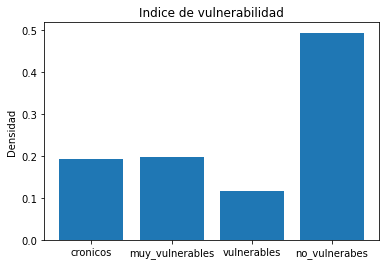

In [39]:
#Graficamos el Indice de vulnerabilidad
eje_x = list(vulnerabilidad.keys())
eje_y = list(vulnerabilidad.values())
plt.bar(eje_x, eje_y)
plt.ylabel('Densidad')
plt.title('Indice de vulnerabilidad')
plt.show()

# Interpretación:

- Casi el 20% de los individuos se encuentra los 4 periodos por debajo de la línea de la pobreza.
- Casi el 50% de los individuos se encontró en alguno de los 4 periodos por debajo de la linea de la pobreza. 

In [40]:
#Hacemos estadistica descriptiva entre grupos
vulnerabilidad = respondieron.groupby(["CODUSU","COMPONENTE"]).agg({"pobre":"sum", "CH12": "max"})

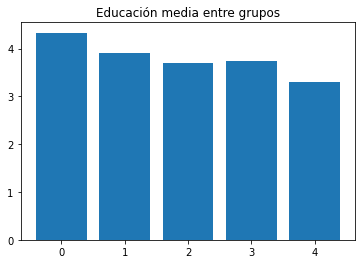

In [41]:
hi = vulnerabilidad.groupby(["pobre"]).agg({"CH12": "mean"})
hi.reset_index(inplace=True)

x_values = hi['pobre']
y_values = hi['CH12']
plt.title('Educación media entre grupos')
plt.bar(x_values, y_values)
plt.show()
plt.close('all')

In [42]:
cronicos = vulnerabilidad[(vulnerabilidad["pobre"]==4)].pobre.count()

cronicos_1 = vulnerabilidad[(vulnerabilidad["pobre"]==4)&
                            ((vulnerabilidad["CH12"]==0)|
                            (vulnerabilidad["CH12"]==1)|
                            (vulnerabilidad["CH12"]==2)|
                            (vulnerabilidad["CH12"]==3))].pobre.count()
cronicos_2 = vulnerabilidad[(vulnerabilidad["pobre"]==4)&
                            ((vulnerabilidad["CH12"]==4)|
                           (vulnerabilidad["CH12"]==5))].pobre.count()
cronicos_3 = vulnerabilidad[(vulnerabilidad["pobre"]==4)&
                            ((vulnerabilidad["CH12"]==6)|
                           (vulnerabilidad["CH12"]==7)|
                           (vulnerabilidad["CH12"]==8)|
                           (vulnerabilidad["CH12"]==9))].pobre.count()

muy_vulnerables = vulnerabilidad[(vulnerabilidad["pobre"]==3)|(vulnerabilidad["pobre"]==2)].pobre.count()
muy_vulnerables1 = vulnerabilidad[((vulnerabilidad["pobre"]==3)|(vulnerabilidad["pobre"]==2))&
                                   ((vulnerabilidad["CH12"]==0)|
                                   (vulnerabilidad["CH12"]==1)|
                                   (vulnerabilidad["CH12"]==2)|
                                   (vulnerabilidad["CH12"]==3))].pobre.count()
muy_vulnerables2 = vulnerabilidad[((vulnerabilidad["pobre"]==3)|(vulnerabilidad["pobre"]==2))&
                                   ((vulnerabilidad["CH12"]==4)|
                                   (vulnerabilidad["CH12"]==5))].pobre.count()
muy_vulnerables3 = vulnerabilidad[((vulnerabilidad["pobre"]==3)|(vulnerabilidad["pobre"]==2))&
                                 ((vulnerabilidad["CH12"]==6)|
                                 (vulnerabilidad["CH12"]==7)|
                                 (vulnerabilidad["CH12"]==8)|
                                 (vulnerabilidad["CH12"]==9))].pobre.count()
 
vulnerables = vulnerabilidad[(vulnerabilidad["pobre"]==1)].pobre.count()
vulnerables_1 = vulnerabilidad[(vulnerabilidad["pobre"]==1)&
                               ((vulnerabilidad["CH12"]==0)|
                                (vulnerabilidad["CH12"]==1)|
                                (vulnerabilidad["CH12"]==2)|
                                (vulnerabilidad["CH12"]==3))].pobre.count()
vulnerables_2 = vulnerabilidad[(vulnerabilidad["pobre"]==1)&
                                ((vulnerabilidad["CH12"]==4)|
                                (vulnerabilidad["CH12"]==5))].pobre.count()
vulnerables_3 = vulnerabilidad[(vulnerabilidad["pobre"]==1)&
                               ((vulnerabilidad["CH12"]==6)|
                                 (vulnerabilidad["CH12"]==7)|
                                 (vulnerabilidad["CH12"]==8)|
                                 (vulnerabilidad["CH12"]==9))].pobre.count()

no_vulnerables = vulnerabilidad[(vulnerabilidad["pobre"]==0)].pobre.count()
no_vulnerables_1 = vulnerabilidad[(vulnerabilidad["pobre"]==0)&
                                ((vulnerabilidad["CH12"]==0)|
                                (vulnerabilidad["CH12"]==1)|
                                (vulnerabilidad["CH12"]==2)|
                                (vulnerabilidad["CH12"]==3))].pobre.count()
no_vulnerables_2 = vulnerabilidad[(vulnerabilidad["pobre"]==0)&
                                  ((vulnerabilidad["CH12"]==4)|
                                  (vulnerabilidad["CH12"]==5))].pobre.count()
no_vulnerables_3 = vulnerabilidad[(vulnerabilidad["pobre"]==0)&
                                 ((vulnerabilidad["CH12"]==6)|
                                 (vulnerabilidad["CH12"]==7)|
                                 (vulnerabilidad["CH12"]==8)|
                                 (vulnerabilidad["CH12"]==9))].pobre.count()


total = no_vulnerables + vulnerables + muy_vulnerables + cronicos

In [43]:
cro = {"baja": cronicos_1/cronicos, "media": cronicos_2/cronicos, "alta": cronicos_3/cronicos}
muy = {"1": muy_vulnerables1/muy_vulnerables, "2": muy_vulnerables2/muy_vulnerables, "3": muy_vulnerables3/muy_vulnerables}
vul = {"1": vulnerables_1/vulnerables, "2": vulnerables_2/vulnerables, "3": vulnerables_3/vulnerables}
no = {"1": no_vulnerables_1/no_vulnerables, "2": no_vulnerables_2/no_vulnerables, "3": no_vulnerables_3/no_vulnerables}

ff = ["cronicos", "muy_vulnerables", "vulnerables", "no_vulnerables"]
lista_cro = cro.values()
lista_cro = list(lista_cro)
lista_muy = muy.values()
lista_muy = list(lista_muy)
lista_vul = vul.values()
lista_vul = list(lista_vul)
lista_no = no.values()
lista_no = list(lista_no)
lista_key = cro.keys()
lista_key = list(lista_key)

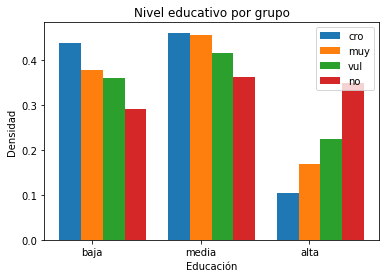

In [44]:
numero_de_grupos = len(lista_cro)
indice_barras = np.arange(numero_de_grupos)
ancho_barras =0.20
 
plt.bar(indice_barras, lista_cro, width=ancho_barras, label='cro')
plt.bar(indice_barras + ancho_barras, lista_muy, width=ancho_barras, label='muy')
plt.bar(indice_barras + ancho_barras*2, lista_vul, width=ancho_barras, label='vul')
plt.bar(indice_barras + ancho_barras*3, lista_no, width=ancho_barras, label='no')

plt.legend(loc='best')
## Se colocan los indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, (lista_key))
 
plt.ylabel('Densidad')
plt.xlabel('Educación')
plt.title('Nivel educativo por grupo')
 
plt.show()

# Hacemos matriz de correlaciones para variables significativas

Y capaz un gráfico como el de arriba para otra variable

Y ya terminamos con la estadistica descriptiva.

# Predicciones

In [89]:
subrespondieron = respondieron[((respondieron["TRIMESTRE"]==3) & (respondieron["ANO4"]==2016) & (respondieron["i"]==1)) | 
                 ((respondieron["TRIMESTRE"]==4) & (respondieron["ANO4"]==2016) & (respondieron["j"]==1))]

subrespondieron.reset_index(inplace=True,drop=True)

In [90]:
subrespondieron.drop(["pobre_final","j","i","CODUSU","pobre_prox","ANO4",
                      "PONDIH","PONDERA","adulto_equiv","ad_equiv_hogar","ingreso_necesario"],axis=1,inplace=True)

C:\Users\felip\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [93]:
x = subrespondieron.iloc[:, :-1]
y = subrespondieron["pobre_anual"]

#creamos una copia del dataframe para luego recuperar las columnas que no son categóricas
x_temp = x.copy()

# Herramienta para poder utilizar variables categóricas en los modelos.
label_encoder = preprocessing.LabelEncoder()

# Le aplico la herramienta al df
x = x.apply(label_encoder.fit_transform)

# Volvemos a introducir las columnas no categóricas 
x[["PP3E_TOT","PP3F_TOT","PP04B3_ANO","ADECIFR","DECIFR","DECCFR","ADECCFR","PP08D1","P21","DECOCUR","P47T","TOT_P12",
   "IX_TOT","IX_MEN10","ITF","IV2","IPCF"]] = x_temp[["PP3E_TOT","PP3F_TOT","PP04B3_ANO","ADECIFR","DECIFR",
                                                      "DECCFR","ADECCFR","PP08D1","P21","DECOCUR","P47T","TOT_P12",
                                                      "IX_TOT","IX_MEN10","ITF","IV2","IPCF"]]

x["inter"] = 1

In [108]:
def evalua_metodo(X_train, X_test, y_train, y_test, modelo, parametro=1.0, n=5):
    '''
    Función que reporta métricas de evaluación de un modelo a elección.
    
    input:
        X_train: X de entrenamiento.
        X_test: X de evaluación.
        y_train: Y de entrenamiento.
        y_test: Y de evaluación.
        modelo: Elección de modelo, default = Logit. (Logit = "Logit", Lineal = "Lineal", KNN = "KNN", Lasso = "Lasso",
                                                      Ridge = "Ridge", Elastic net = "ElasticNet", CART = "CART", 
                                                      SVM = "SVM", Bagging = "Bagging", Random Forest = "RandomForest", 
                                                      Boosting = Boosting").
        parametro: Parámetro de regularización de los modelos. Por default = 1.0
        n: Parámetro para definir la catnidad de n-neighbours en KNN. Por default = 5.
        
    output:
        Df con las columnas: (modelo, ecm, parámetro, accuracy, matriz_confusion, auc)
        coe: En el caso de un modelo "Lasso", se define una variable global con los coeficientes de las variables X.
        
    '''
    ev_modelo = pd.DataFrame(columns=["modelo", "ecm", "parámetro", "auc", "accuracy", "fpr", "tpr"])
    
    # Filtro para distintos modelos.
    pob = LogisticRegression(max_iter = 5000, fit_intercept = False)
    if modelo == "Lineal":
        pob = LinearDiscriminantAnalysis()
    elif modelo == "KNN":
        pob = KNeighborsClassifier(n_neighbors = int(n))
    elif modelo == "Logit":
        pob = LogisticRegression(max_iter = 5000, fit_intercept = False)
    elif modelo == "Lasso":
        pob = LogisticRegression(penalty = "l1", max_iter = 5000, 
                                 fit_intercept = False, solver = "liblinear", C = parametro)
    elif modelo == "Ridge":
        pob = LogisticRegression(penalty = "l2", max_iter = 5000, 
                                 fit_intercept = False, solver = "liblinear", C = parametro)
    elif modelo == "ElasticNet":
        pob = LogisticRegression(penalty = "elasticnet", max_iter = 5000, 
                                 fit_intercept = False, solver = "saga", C = parametro)
    elif modelo == "CART":
        pob = DecisionTreeClassifier(ccp_alpha = parametro)
    elif modelo == "SVM":
        pob = SVC(C = parametro,gamma='auto')
    elif modelo == "Bagging":
        pob = BaggingClassifier(base_estimator=SVC(C = parametro))
    elif modelo == "RandomForest":
        pob = RandomForestClassifier(ccp_alpha = parametro)
    elif modelo == "Boosting":
        pob = GradientBoostingClassifier(learning_rate=1.0, ccp_alpha = parametro)
    
    # Ajustamos el modelo        
    pob = pob.fit(X_train, y_train)     
    
    # Luego predecimos y con las X de evaluación.
    y_pred = pob.predict(X_test)
    
    if modelo != "SVM":
        # Probabilidad de que Y tome valor 1 segun el valor de X 
        y_pred_proba = pob.predict_proba(X_test)[:,1]

    #Valores de Accuracy
    accuracy_pob = accuracy_score(y_test, y_pred)

    #Matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)

    if modelo != "SVM":
        #Valores de AUC
        auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    if modelo != "SVM":
        #Curva ROC
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
        def ROC(roc):
            display.plot()  
            plt.plot([0, 1], [0, 1], color='red', linestyle='--')
            plt.show()
        ROC(display)

    # Error cuadrático medio
        
    ecm = mean_squared_error(y_pred, y_test)
    
    if modelo != "SVM":
        ev_modelo = ev_modelo.append({"modelo": modelo, "ecm": ecm, 
                                      "parámetro":parametro, "auc":auc,
                                      "accuracy":accuracy_pob, "fpr":fpr, "tpr":tpr}, ignore_index=True)
    elif modelo == "SVM":
        ev_modelo = ev_modelo.append({"modelo": modelo, "ecm": ecm, 
                                      "parámetro":parametro,
                                      "accuracy":accuracy_pob}, ignore_index=True)
    
    return ev_modelo

In [109]:
def cross_validation(x, y, k, modelo, parametro=1.0):
    '''
    Función que realiza validación cruzada con k iteraciones para cierto modelo.
    
    input:
        x: Variables explicativas.
        y: Variable dependiente.
        k: Cantidad de particiones de los datos.
        modelo: Elección de modelo, default = Logit. (Logit = "Logit", Lineal = "Lineal", KNN = "KNN", Lasso = "Lasso",
                                                      Ridge = "Ridge", Elastic net = "ElasticNet", CART = "CART", 
                                                      SVM = "SVM", Bagging = "Bagging", Random Forest = "RandomForest", 
                                                      Boosting = Boosting").
        parametro: Parámetro de regularización de los modelos. Por default = 1.0
        n: Parámetro para definir la catnidad de n-neighbours en KNN. Por default = 5.
        
    output:
        Df con las columnas: (modelo, particion, ecm, accuracy, matriz_confusion, auc, fpr, tpr)
        coe_cv: En el caso de un modelo "Lasso", se define un df global con los coeficientes de las variables X para las 
                k particiones por CV.
    '''
    # Creo el df ecms
    ecms = pd.DataFrame(columns=["modelo", "particion", "ecm", "parámetro", "auc", "accuracy", "fpr", "tpr"])
    
    kf = KFold(n_splits = k, shuffle = True)
    
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
        
        ev_modelo = evalua_metodo(x_train, x_test, y_train, y_test, modelo, parametro)
        
        ecms = ecms.append({"modelo":ev_modelo["modelo"].item(), 
                            "particion": i, "ecm":ev_modelo["ecm"].item(), 
                            "parámetro":parametro, "auc":ev_modelo["auc"].item(),
                            "accuracy":ev_modelo["accuracy"].item(), "fpr":ev_modelo["fpr"].item(),
                            "tpr":ev_modelo["tpr"].item()}, ignore_index=True)
        
        ecms = ecms.astype({"particion":int})
        
    return ecms 

In [110]:
def evalua_config(lista_parametros, x, y, k, modelo):
    '''
    Función que selecciona los hiperparámetros que menor ECM generen, mediante Cross-Validation.
    
    input:
        lista_parametros: lista de parámetros de regularización de los modelos que se van a usar para evaluar.
        x: Variables explicativas.
        y: Variable dependiente.
        k: Cantidad de particiones de los datos.
        modelo: Elección de modelo, default = Logit. (Logit = "Logit", Lineal = "Lineal", KNN = "KNN", Lasso = "Lasso",
                                                      Ridge = "Ridge", Elastic net = "ElasticNet", CART = "CART", 
                                                      SVM = "SVM", Bagging = "Bagging", Random Forest = "RandomForest", 
                                                      Boosting = Boosting").

    output:
        todos: df que contiene la información del modelo utilizado con las columnas
               (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr).
        ecms_avg: df que hace el promedio por parámetro, con las columnas 
                  (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr)
        ev_modelo: df que contiene la información del mejor modelo elegido por ECM, con las columnas 
                  (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr)
        coe_cvs: En el caso de un modelo "Lasso", se define un df global con los coeficientes de las variables X para las 
                k particiones por CV.
    '''
    # Defino data frames para usar después
    
    todos = pd.DataFrame(columns=["modelo", "particion", "ecm", "parámetro", "auc", "accuracy", "fpr", "tpr"])

    # For loop que para cada parámetro corre Cross validation con k particiones.
    for i in lista_parametros:
        ecms = cross_validation(x, y, k, modelo, i)
        # ecmss es un df que guarda los resultados de todos los parámetros k veces.
        todos = todos.append(ecms)
        
    # ecms_avg es un df que guarda los resultados de todos los parámetros haciendo un promedio de todos los ECM de ecmss
    ecms_avg = todos.groupby("parámetro").agg({"ecm":"mean", "modelo":"max", "auc":"mean",
                                               "accuracy":"mean"}).reset_index()
    
    min_ecm = np.Inf
    mejor_parametro = None
    # For loop que permite determinar el parámetro que tiene el menor ECM en promedio.
    for index, row in ecms_avg.iterrows():
        if row["ecm"] < min_ecm:
            min_ecm = row["ecm"]
            mejor_parametro = float(row["parámetro"])
    print("El minimo error es ", min_ecm, " y se da con un parametro de ", mejor_parametro)
    
    # Corro el modelo con el parámetro seleccionado con menor ECM en promedio.
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    ev_modelo = evalua_metodo(X_train, X_test, y_train, y_test, modelo, mejor_parametro)
    
    return (todos, ecms_avg, ev_modelo)

In [111]:
def evalua_multiples_metodos(lista_parametros, x, y, k):
    '''
    Función que corre múltiples métodos para diferentes parámetros los hiperparámetros que menor ECM generen, 
    mediante Cross-Validation.
    
    input:
        lista_parametros: lista de parámetros de regularización de los modelos que se van a usar para evaluar.
        x: Variables explicativas.
        y: Variable dependiente.
        k: Cantidad de particiones de los datos.

    output:
        lista_todos: df que contiene la información de todos los modelos utilizados con las columnas
               (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr).
        lista_promedios: df que hace el promedio por parámetro de los diferentes modelos, con las columnas 
                  (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr)
        lista_mejores: df que contiene la información de los mejores modelos elegido por ECM en los distintos modelos,
                       con las columnas 
                  (modelo, particion, ecm, parámetro, accuracy, auc, fpr, tpr)
    '''
    
    lista_todos = pd.DataFrame(columns=["modelo", "particion", "ecm", "parámetro", "auc", "accuracy", "fpr", "tpr"])
    lista_promedios = pd.DataFrame(columns=["modelo", "parámetro", "ecm", "auc", "accuracy"])
    lista_mejores = pd.DataFrame(columns=["modelo", "ecm", "parámetro", "auc", "accuracy", "fpr", "tpr"])
    
    modelos = ["Lineal", "KNN", "Logit", "CART", "SVM", "Bagging", "RandomForest", "Boosting", "Lasso", "Ridge"]
    for modelo in modelos:
        todos, ecms_avg, ev_modelo = evalua_config(lista_parametros, x, y, k, modelo)
        lista_todos = lista_todos.append(todos)
        lista_promedios = lista_promedios.append(ecms_avg)
        lista_mejores = lista_mejores.append(ev_modelo)
        
    return (lista_todos, lista_promedios, lista_mejores)

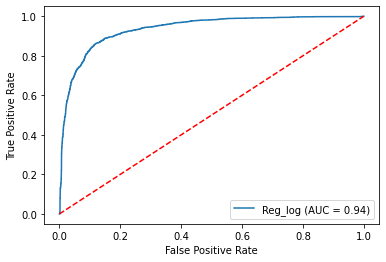

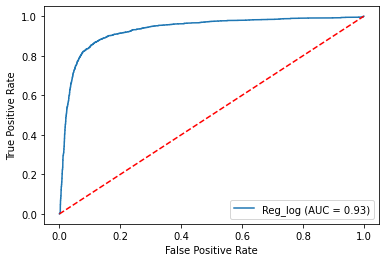

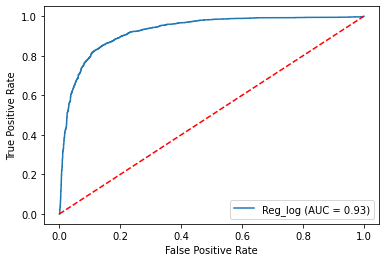

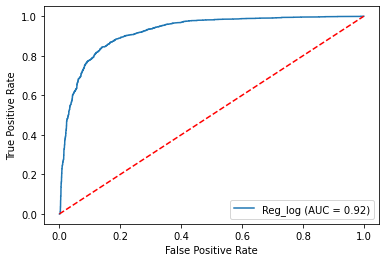

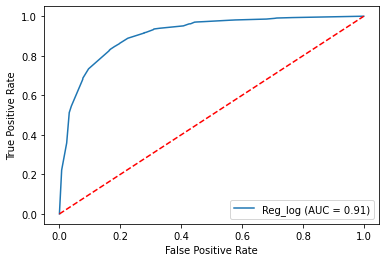

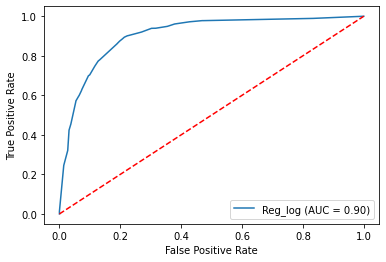

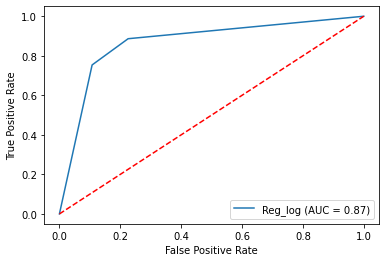

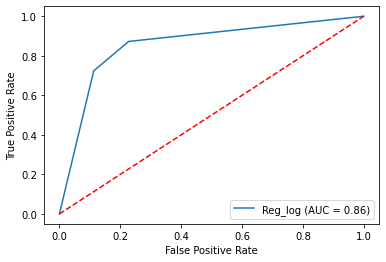

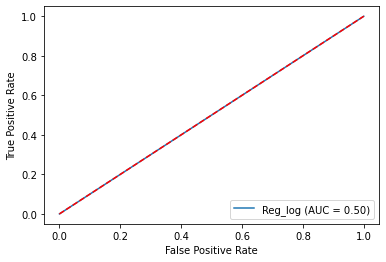

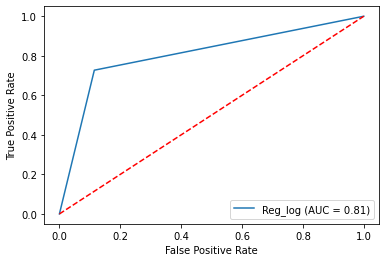

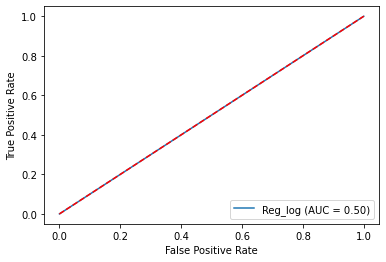

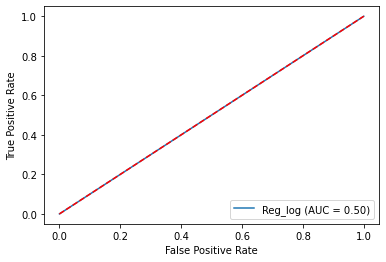

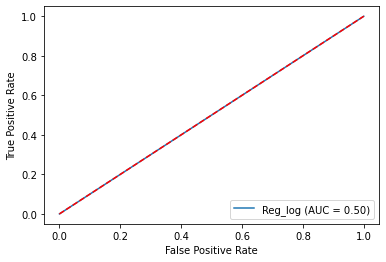

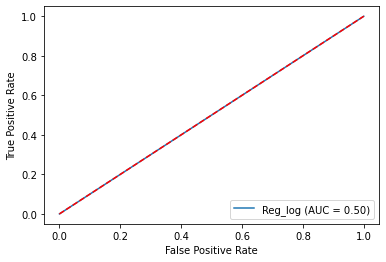

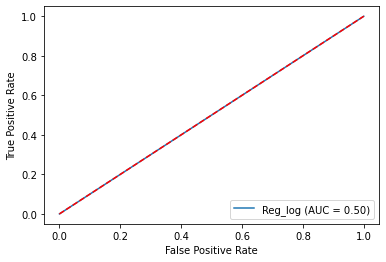

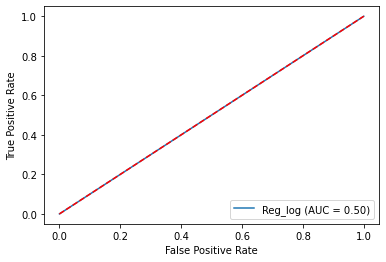

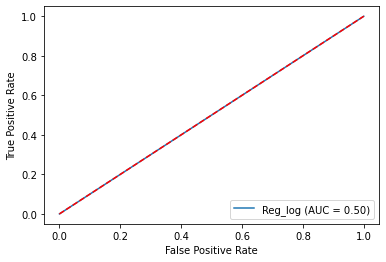

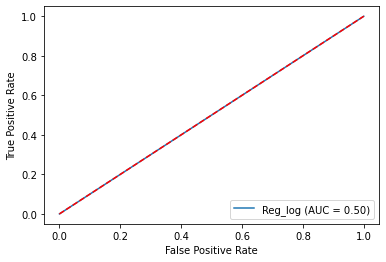

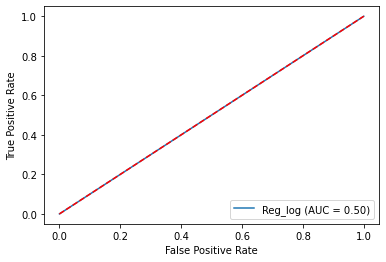

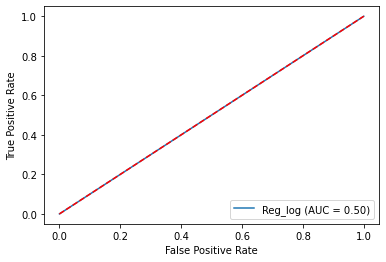

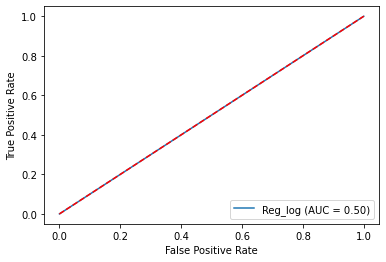

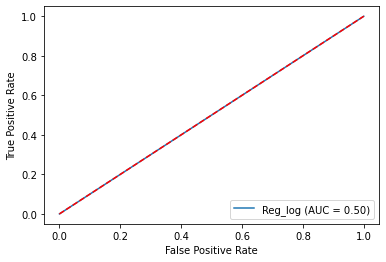

El minimo error es  0.12445494186046512  y se da con un parametro de  1e-05


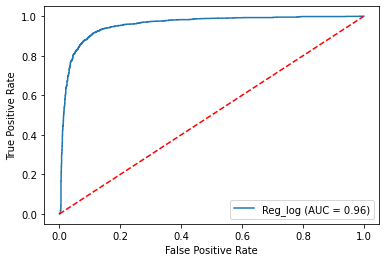

In [116]:
lista = 10**np.linspace(-5,5,11)
todo, prom, modelo = evalua_config(lista,x,y,2,"Boosting")

In [117]:
todo

,modelo,particion,ecm,parámetro,auc,accuracy,fpr,tpr
0,Boosting,0,0.127180,0.00001,0.935338,0.872820,"[0.0, 0.0003031221582297666, 0.001212488632919...","[0.0, 0.0, 0.0, 0.0013605442176870747, 0.00136..."
1,Boosting,1,0.121730,0.00001,0.930882,0.878270,"[0.0, 0.0006127450980392157, 0.000612745098039...","[0.0, 0.0008928571428571428, 0.003571428571428..."
0,Boosting,0,0.139353,0.00010,0.925417,0.860647,"[0.0, 0.0006112469437652812, 0.000611246943765...","[0.0, 0.0, 0.0008960573476702509, 0.0017921146..."
1,Boosting,1,0.147347,0.00010,0.921611,0.852653,"[0.0, 0.0, 0.00030385900941962927, 0.000303859...","[0.0, 0.00045187528242205153, 0.00045187528242..."
0,Boosting,0,0.167151,0.00100,0.909050,0.832849,"[0.0, 0.0073461891643709825, 0.023875114784205...","[0.0, 0.22172552525704067, 0.35896289673670095..."
1,Boosting,1,0.167696,0.00100,0.904980,0.832304,"[0.0, 0.0, 0.0, 0.014259708737864078, 0.027305...","[0.0, 0.009510869565217392, 0.0126811594202898..."
0,Boosting,0,0.163154,0.01000,0.867757,0.836846,"[0.0, 0.10740291262135922, 0.22572815533980584...","[0.0, 0.7536231884057971, 0.886322463768116, 1.0]"
1,Boosting,1,0.179142,0.01000,0.855696,0.820858,"[0.0, 0.11264156718702173, 0.22773186409550045...","[0.0, 0.723737147966026, 0.8725972284309342, 1.0]"
0,Boosting,0,0.412791,0.10000,0.500000,0.587209,"[0.0, 1.0]","[0.0, 1.0]"
1,Boosting,1,0.177144,0.10000,0.806213,0.822856,"[0.0, 0.11468027619333533, 1.0]","[0.0, 0.7271053842613898, 1.0]"


In [118]:
prom

,parámetro,ecm,modelo,auc,accuracy
0,0.00001,0.124455,Boosting,0.933110,0.875545
1,0.00010,0.143350,Boosting,0.923514,0.856650
2,0.00100,0.167424,Boosting,0.907015,0.832576
3,0.01000,0.171148,Boosting,0.861727,0.828852
4,0.10000,0.294967,Boosting,0.653106,0.705033
5,1.00000,0.403797,Boosting,0.500000,0.596203
6,10.00000,0.403797,Boosting,0.500000,0.596203
7,100.00000,0.403797,Boosting,0.500000,0.596203
8,1000.00000,0.403797,Boosting,0.500000,0.596203
9,10000.00000,0.403797,Boosting,0.500000,0.596203


Preguntar para que cantidad de iteraciones y que parametros para cada modelo. 
Correr todos los modelos con variables de ingreso y sin variables de ingreso
Analizar y comparar eficacia de ambas. 
Analizar coeficientes Lasso y Ridge de ambas. Printear y comparar arból Cart de ambas. 